# Limpieza de datos

Los datos que utlizaremos son proporcionados por la empresa "Bosch". La compañía está interesada en predecir cuando uno de sus productos  presentará fallas internas, esto es posible porque Bosch guarda muchos datos a lo largo de la linea de ensamblaje, datos que incluyen miles de medidas y pruebas efectuadas a los componentes. Esto permitiría a Bosch dar mayor calidad a menos costo a los usuarios finales de sus productos.

(la data se encuentra en https://www.kaggle.com/c/bosch-production-line-performance/overview)



In [1]:
!pip install -U plotly

     |████████████████████████████████| 27.7 MB 2.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [2]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve, precision_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Lectura de los datos**

Los datos son medidas que se toman a las partes en la línea de producción. Cada parte tiene un Id único. Se buscará predecir si una parte falla el control de calidad (Se representará como un 'Response' = 1).

Los datos contienen un gran número de características (features). Estos nos dicen la linea de producción, la estación en la línea y la característica. Eg. L3_S36_F3939 nos dice que es una característica medida en la linea 3, estación 36 y número de característica 3939.



In [4]:
path = '/content/drive/MyDrive/Curso-WorkingAnalyst/semana1/'

In [5]:
tamanio = 10000

los1 = pd.DataFrame()
los0 = pd.DataFrame()

np.seed(42)

In [6]:
for cosa in pd.read_csv(path + 'train_numeric.csv.zip', chunksize=tamanio):

  apendizar_unos = cosa[cosa['Response']==1]
  los1 = pd.concat([los1, apendizar_unos])

  lista = np.random.randint(0,len(cosa[cosa['Response']==0]), size=160)
  apendizar_ceros = cosa[cosa['Response']==0].iloc[lista,:]
  los0 = pd.concat([los0, apendizar_ceros])
  

In [ ]:
# total de 1's: 6879

In [ ]:
# total de 0's: 1176868

In [7]:
los1.info()
print('-----------------')
los0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6879 entries, 539 to 1183337
Columns: 970 entries, Id to Response
dtypes: float64(968), int64(2)
memory usage: 51.0 MB
-----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19040 entries, 8210 to 1183461
Columns: 970 entries, Id to Response
dtypes: float64(968), int64(2)
memory usage: 141.1 MB


Posibilidades:  

*   Primero unir los DataFrames y empezar a limpiar
*   Limpiar por separado y luego unir

Primero haremos la unión y despues la limpieza y le llamaremos 'data_1'

In [8]:
# Este DataFrame tiene 27109 filas
data_1 = pd.concat([los1, los0])

In [9]:
# Nuestros datos tendran cierta cantidad de 0's y 1's

data_1.Response.value_counts()

0    19040
1     6879
Name: Response, dtype: int64

In [10]:
# Procedamos a limpiar los datos: Primero removeremos las columnas con mas de 15% de valores nulos

data_1_copia = data_1.copy()
null_val_1 = data_1_copia.isnull().mean()
null_columns_1 = null_val_1[null_val_1>0.15]
print(null_columns_1)

L0_S0_F0        0.443458
L0_S0_F2        0.443458
L0_S0_F4        0.443458
L0_S0_F6        0.443458
L0_S0_F8        0.443458
                  ...   
L3_S50_F4253    0.974382
L3_S51_F4256    0.950963
L3_S51_F4258    0.950963
L3_S51_F4260    0.950963
L3_S51_F4262    0.950963
Length: 861, dtype: float64


In [11]:
null_columns_1.min()

0.31853080751572205

In [12]:
columns_to_drop = null_columns_1.index
df_num_drop = data_1_copia.drop(columns=columns_to_drop)
df_num_drop

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,...,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
539,1053,-0.032,-0.097,-0.104,0.056,-0.016,-0.025,0.063,0.044,-0.028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
633,1250,0.252,-0.190,-0.147,0.023,-0.067,-0.095,0.006,0.057,0.002,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
681,1350,-0.147,-0.082,0.019,0.078,-0.100,-0.101,0.013,0.064,0.053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
887,1793,-0.216,0.185,0.072,-0.207,0.032,0.041,-0.012,-0.092,-0.012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1152,2347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180766,2361502,-0.014,0.134,-0.147,-0.085,0.163,0.133,-0.006,-0.027,0.209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1183544,2367091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1182395,2364811,-0.096,-0.149,-0.104,0.165,-0.062,-0.071,-0.038,-0.040,0.037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1183066,2366149,0.182,-0.030,-0.151,-0.097,-0.073,-0.053,-0.088,-0.144,-0.090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
nulos_desp_drop = df_num_drop.isnull().mean()
print(nulos_desp_drop)

Id              0.000000
L3_S29_F3315    0.052857
L3_S29_F3318    0.052857
L3_S29_F3321    0.052857
L3_S29_F3324    0.052857
                  ...   
L3_S37_F3944    0.052085
L3_S37_F3946    0.052085
L3_S37_F3948    0.052085
L3_S37_F3950    0.052085
Response        0.000000
Length: 109, dtype: float64


In [14]:
# La columna que tiene mayor porcentaje de NaN
nulos_desp_drop.max()

0.09433234306879124

In [15]:
df_num_drop.isnull().sum()

Id                 0
L3_S29_F3315    1370
L3_S29_F3318    1370
L3_S29_F3321    1370
L3_S29_F3324    1370
                ... 
L3_S37_F3944    1350
L3_S37_F3946    1350
L3_S37_F3948    1350
L3_S37_F3950    1350
Response           0
Length: 109, dtype: int64

In [16]:
df_num_drop.dropna(axis=0, inplace=True)

In [18]:
# Habia 25919 datos, al quitar los NaN quedan 22421
df_num_drop

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,...,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
539,1053,-0.032,-0.097,-0.104,0.056,-0.016,-0.025,0.063,0.044,-0.028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
681,1350,-0.147,-0.082,0.019,0.078,-0.100,-0.101,0.013,0.064,0.053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
887,1793,-0.216,0.185,0.072,-0.207,0.032,0.041,-0.012,-0.092,-0.012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1731,3527,-0.210,0.082,0.120,0.056,-0.116,-0.087,0.258,0.213,-0.166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1759,3585,-0.171,0.222,-0.216,-0.054,0.017,0.007,0.006,0.019,0.256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183049,2366120,-0.280,-0.082,-0.039,0.012,-0.027,-0.012,-0.025,-0.001,0.079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1180766,2361502,-0.014,0.134,-0.147,-0.085,0.163,0.133,-0.006,-0.027,0.209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1182395,2364811,-0.096,-0.149,-0.104,0.165,-0.062,-0.071,-0.038,-0.040,0.037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1183066,2366149,0.182,-0.030,-0.151,-0.097,-0.073,-0.053,-0.088,-0.144,-0.090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [19]:
df_num_drop.Response.value_counts()

0    17105
1     5316
Name: Response, dtype: int64

In [20]:
df_num_drop.isnull().sum().sum()

0

# Segundo Dataset, con OneHotEncoder

In [21]:
copia0 = los0.copy()
copia1 = los1.copy()

Limpiar cada dataset de nulos, depues unirlos y utilizar OneHotEncoding

In [22]:
null_copia0 = copia0.isnull().mean()
null_columns_copia0 = null_copia0[null_copia0 > 0.15]
print(null_columns_copia0)

columns_to_drop = null_columns_copia0.index
df_copia0_drop = copia0.drop(columns=columns_to_drop)
df_copia0_drop

df_copia0_drop.dropna(axis=0, inplace=True)
df_copia0_drop
# Este tiene 109 features

L0_S0_F0        0.431880
L0_S0_F2        0.431880
L0_S0_F4        0.431880
L0_S0_F6        0.431880
L0_S0_F8        0.431880
                  ...   
L3_S50_F4253    0.973424
L3_S51_F4256    0.949107
L3_S51_F4258    0.949107
L3_S51_F4260    0.949107
L3_S51_F4262    0.949107
Length: 861, dtype: float64


,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,...,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
8210,16305,-0.236,-0.047,-0.157,-0.218,-0.082,-0.071,0.006,0.057,0.140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4973,9933,-0.280,-0.190,0.408,-0.097,0.191,0.233,0.006,0.032,0.131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3268,6576,-0.084,-0.139,-0.127,0.150,0.139,0.133,-0.050,-0.027,-0.090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4197,8362,-0.216,-0.030,0.072,0.012,0.058,0.060,-0.006,-0.040,-0.142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2341,4714,-0.032,-0.097,0.008,0.275,0.012,-0.009,-0.031,-0.046,0.050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183049,2366120,-0.280,-0.082,-0.039,0.012,-0.027,-0.012,-0.025,-0.001,0.079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1180766,2361502,-0.014,0.134,-0.147,-0.085,0.163,0.133,-0.006,-0.027,0.209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1182395,2364811,-0.096,-0.149,-0.104,0.165,-0.062,-0.071,-0.038,-0.040,0.037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1183066,2366149,0.182,-0.030,-0.151,-0.097,-0.073,-0.053,-0.088,-0.144,-0.090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [23]:
null_copia1 = copia1.isnull().mean()
null_columns_copia1 = null_copia1[null_copia1 > 0.15]
print(null_columns_copia1)

columns_to_drop = null_columns_copia1.index
df_copia1_drop = copia1.drop(columns=columns_to_drop)
df_copia1_drop

df_copia1_drop.dropna(axis=0, inplace=True)
df_copia1_drop
# Este solo tiene 95 features

L0_S0_F0        0.475505
L0_S0_F2        0.475505
L0_S0_F4        0.475505
L0_S0_F6        0.475505
L0_S0_F8        0.475505
                  ...   
L3_S50_F4253    0.977032
L3_S51_F4256    0.956098
L3_S51_F4258    0.956098
L3_S51_F4260    0.956098
L3_S51_F4262    0.956098
Length: 875, dtype: float64


,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,...,L3_S30_F3809,L3_S30_F3814,L3_S30_F3819,L3_S30_F3824,L3_S30_F3829,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
539,1053,-0.032,-0.097,-0.104,0.056,-0.016,-0.025,0.063,0.044,-0.028,...,0.128,0.013,0.057,0.013,0.105,0.0,0.0,0.0,0.0,1
633,1250,0.252,-0.190,-0.147,0.023,-0.067,-0.095,0.006,0.057,0.002,...,-0.004,0.013,-0.007,0.013,-0.036,0.0,0.0,0.0,0.0,1
681,1350,-0.147,-0.082,0.019,0.078,-0.100,-0.101,0.013,0.064,0.053,...,-0.027,0.013,-0.011,0.013,-0.036,0.0,0.0,0.0,0.0,1
887,1793,-0.216,0.185,0.072,-0.207,0.032,0.041,-0.012,-0.092,-0.012,...,0.031,0.013,0.015,0.013,-0.001,0.0,0.0,0.0,0.0,1
1731,3527,-0.210,0.082,0.120,0.056,-0.116,-0.087,0.258,0.213,-0.166,...,0.008,0.013,0.005,0.013,0.018,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,2365879,-0.280,-0.190,0.073,0.023,0.012,0.010,0.101,0.070,0.131,...,-0.709,-0.987,-0.306,-0.987,-0.416,0.0,0.0,0.0,0.0,1
1183052,2366124,0.182,-0.030,-0.099,-0.146,-0.055,-0.042,0.050,-0.007,-0.116,...,-0.057,0.013,-0.027,0.013,0.086,0.0,0.0,0.0,0.0,1
1183093,2366209,0.119,0.134,0.073,-0.085,-0.040,-0.021,-0.075,-0.014,0.157,...,-0.019,0.013,-0.007,0.013,0.012,0.0,0.0,0.0,0.0,1
1183242,2366505,-0.236,0.061,0.181,0.223,-0.054,-0.042,0.006,0.064,0.088,...,0.056,0.013,0.025,0.013,0.025,0.0,0.0,0.0,0.0,1


In [24]:
# Interseccion de 2 Array de numpy
a = np.intersect1d(df_copia0_drop.columns, df_copia1_drop.columns, assume_unique=True, return_indices=False)
a

array(['Id', 'L3_S29_F3315', 'L3_S29_F3318', 'L3_S29_F3321',
       'L3_S29_F3324', 'L3_S29_F3327', 'L3_S29_F3330', 'L3_S29_F3333',
       'L3_S29_F3336', 'L3_S29_F3339', 'L3_S29_F3342', 'L3_S29_F3345',
       'L3_S29_F3348', 'L3_S29_F3351', 'L3_S29_F3354', 'L3_S29_F3357',
       'L3_S29_F3360', 'L3_S29_F3367', 'L3_S29_F3370', 'L3_S29_F3373',
       'L3_S29_F3376', 'L3_S29_F3379', 'L3_S29_F3382', 'L3_S29_F3385',
       'L3_S29_F3388', 'L3_S29_F3395', 'L3_S29_F3398', 'L3_S29_F3401',
       'L3_S29_F3404', 'L3_S29_F3407', 'L3_S29_F3412', 'L3_S29_F3421',
       'L3_S29_F3424', 'L3_S29_F3427', 'L3_S29_F3430', 'L3_S29_F3433',
       'L3_S29_F3436', 'L3_S29_F3439', 'L3_S29_F3442', 'L3_S29_F3449',
       'L3_S29_F3452', 'L3_S29_F3455', 'L3_S29_F3458', 'L3_S29_F3461',
       'L3_S29_F3464', 'L3_S29_F3467', 'L3_S29_F3470', 'L3_S29_F3473',
       'L3_S29_F3476', 'L3_S29_F3479', 'L3_S29_F3482', 'L3_S29_F3485',
       'L3_S29_F3488', 'L3_S29_F3491', 'L3_S30_F3494', 'L3_S30_F3499',
       'L3_S30_F

In [25]:
len(a)

95

La intersección dice que todos los features de los 1's tambien la tienen los 0's, pero los ceros tienen ciertas columnas en las que solo ellos tienen valores

In [26]:
# Veamos el DataFrame del resto, sin las columnas que tienen los datasets de 0's y 1's (Response) en común

union = pd.concat([df_copia0_drop,df_copia1_drop])
resto = union.drop(columns=a)

In [27]:
union

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,...,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
8210,16305,-0.236,-0.047,-0.157,-0.218,-0.082,-0.071,0.006,0.057,0.140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4973,9933,-0.280,-0.190,0.408,-0.097,0.191,0.233,0.006,0.032,0.131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3268,6576,-0.084,-0.139,-0.127,0.150,0.139,0.133,-0.050,-0.027,-0.090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4197,8362,-0.216,-0.030,0.072,0.012,0.058,0.060,-0.006,-0.040,-0.142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2341,4714,-0.032,-0.097,0.008,0.275,0.012,-0.009,-0.031,-0.046,0.050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,2365879,-0.280,-0.190,0.073,0.023,0.012,0.010,0.101,0.070,0.131,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
1183052,2366124,0.182,-0.030,-0.099,-0.146,-0.055,-0.042,0.050,-0.007,-0.116,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
1183093,2366209,0.119,0.134,0.073,-0.085,-0.040,-0.021,-0.075,-0.014,0.157,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1
1183242,2366505,-0.236,0.061,0.181,0.223,-0.054,-0.042,0.006,0.064,0.088,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1


In [28]:
# Estas son las columnas que los datos con Response 0 tienen valores y los de Response 1 tiene NaN
resto

,L3_S33_F3855,L3_S33_F3857,L3_S33_F3859,L3_S33_F3861,L3_S33_F3863,L3_S33_F3865,L3_S33_F3867,L3_S33_F3869,L3_S33_F3871,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882
8210,-0.029,-0.037,0.015,-0.029,-0.029,-0.185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4973,0.017,0.004,-0.048,0.017,0.017,0.116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3268,0.108,0.107,0.120,0.108,0.108,-0.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4197,-0.074,-0.069,-0.021,-0.074,-0.074,-0.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2341,0.017,0.003,0.052,0.017,0.017,0.035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
columnas_a_quitar = resto.columns
df = resto.copy()

for col in resto.columns:
  df['T_'+col] = df[col].apply(lambda x:0 if np.isnan(x) else 1)

In [31]:
df

,L3_S33_F3855,L3_S33_F3857,L3_S33_F3859,L3_S33_F3861,L3_S33_F3863,L3_S33_F3865,L3_S33_F3867,L3_S33_F3869,L3_S33_F3871,L3_S33_F3873,...,T_L3_S33_F3863,T_L3_S33_F3865,T_L3_S33_F3867,T_L3_S33_F3869,T_L3_S33_F3871,T_L3_S33_F3873,T_L3_S34_F3876,T_L3_S34_F3878,T_L3_S34_F3880,T_L3_S34_F3882
8210,-0.029,-0.037,0.015,-0.029,-0.029,-0.185,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
4973,0.017,0.004,-0.048,0.017,0.017,0.116,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
3268,0.108,0.107,0.120,0.108,0.108,-0.095,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
4197,-0.074,-0.069,-0.021,-0.074,-0.074,-0.095,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
2341,0.017,0.003,0.052,0.017,0.017,0.035,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1183052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1183093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1183242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df.drop(columns=columnas_a_quitar, inplace=True)

In [33]:
columnas_a_quitar

Index(['L3_S33_F3855', 'L3_S33_F3857', 'L3_S33_F3859', 'L3_S33_F3861',
       'L3_S33_F3863', 'L3_S33_F3865', 'L3_S33_F3867', 'L3_S33_F3869',
       'L3_S33_F3871', 'L3_S33_F3873', 'L3_S34_F3876', 'L3_S34_F3878',
       'L3_S34_F3880', 'L3_S34_F3882'],
      dtype='object')

In [34]:
union.drop(columns=columnas_a_quitar, inplace=True)
union

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,...,L3_S30_F3809,L3_S30_F3814,L3_S30_F3819,L3_S30_F3824,L3_S30_F3829,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
8210,16305,-0.236,-0.047,-0.157,-0.218,-0.082,-0.071,0.006,0.057,0.140,...,-0.002,0.013,0.001,0.013,0.038,0.0,0.0,0.0,0.0,0
4973,9933,-0.280,-0.190,0.408,-0.097,0.191,0.233,0.006,0.032,0.131,...,-0.005,0.013,-0.001,0.013,-0.024,0.0,0.0,0.0,0.0,0
3268,6576,-0.084,-0.139,-0.127,0.150,0.139,0.133,-0.050,-0.027,-0.090,...,-0.053,0.013,-0.023,0.013,-0.001,0.0,0.0,0.0,0.0,0
4197,8362,-0.216,-0.030,0.072,0.012,0.058,0.060,-0.006,-0.040,-0.142,...,0.013,0.013,-0.001,0.013,-0.001,0.0,0.0,0.0,0.0,0
2341,4714,-0.032,-0.097,0.008,0.275,0.012,-0.009,-0.031,-0.046,0.050,...,0.026,0.013,0.011,0.013,-0.036,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,2365879,-0.280,-0.190,0.073,0.023,0.012,0.010,0.101,0.070,0.131,...,-0.709,-0.987,-0.306,-0.987,-0.416,0.0,0.0,0.0,0.0,1
1183052,2366124,0.182,-0.030,-0.099,-0.146,-0.055,-0.042,0.050,-0.007,-0.116,...,-0.057,0.013,-0.027,0.013,0.086,0.0,0.0,0.0,0.0,1
1183093,2366209,0.119,0.134,0.073,-0.085,-0.040,-0.021,-0.075,-0.014,0.157,...,-0.019,0.013,-0.007,0.013,0.012,0.0,0.0,0.0,0.0,1
1183242,2366505,-0.236,0.061,0.181,0.223,-0.054,-0.042,0.006,0.064,0.088,...,0.056,0.013,0.025,0.013,0.025,0.0,0.0,0.0,0.0,1


In [35]:
df

,T_L3_S33_F3855,T_L3_S33_F3857,T_L3_S33_F3859,T_L3_S33_F3861,T_L3_S33_F3863,T_L3_S33_F3865,T_L3_S33_F3867,T_L3_S33_F3869,T_L3_S33_F3871,T_L3_S33_F3873,T_L3_S34_F3876,T_L3_S34_F3878,T_L3_S34_F3880,T_L3_S34_F3882
8210,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4973,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3268,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4197,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2341,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1183052,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1183093,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1183242,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Variables con alta correlación

La **correlación** es una médida estadística que muestra la relación, ya sea causal o no, entre dos variables. La médida más usada es el **Coeficiente de Correlación de Pearson**. Para dos variables $X = (x_1, x_2, \dots, x_n)$ y $Y = (y_1, y_2, \dots, y_n)$,

$$\rho_{X, Y} = corr(X, Y) = \frac{cov(X, Y)}{\sigma_{X}\sigma_{Y}}$$ 

en donde $\sigma_{X}$ es la desviación estándar de $X$ y $$cov(X, Y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \mu_x)(y_i-\mu_y)$$
con $\mu_x$ la media de $X$.



https://www.maximaformacion.es/blog-dat/que-es-la-correlacion-estadistica-y-como-interpretarla/

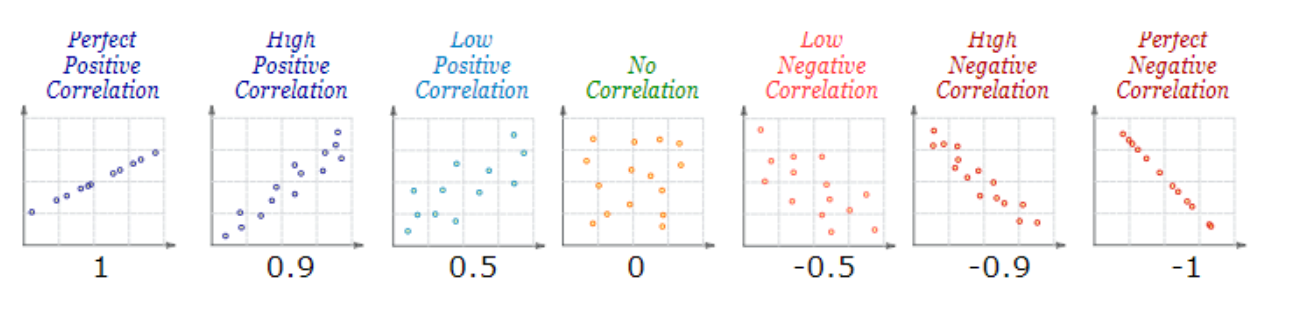

In [36]:
numeric_to_remove = []

In [37]:
# corr_df = X_train[columns_by_type['float64']].corr() # NOTA: Obtenemos la misma matriz de correlación con los datos sin escalar
corr_df = union.corr()
px.imshow(corr_df, 
          labels=dict(color="Correlación"),
          x=corr_df.index, 
          y=corr_df.columns, 
          range_color=[-1, 1], 
          color_continuous_scale="oxy"
          )


In [38]:
correlated_features = set()
for i in range(len(corr_df.columns)):
    for j in range(i):
        if abs(corr_df.iloc[i, j]) > 0.7:
            colname = corr_df.columns[i]
            correlated_features.add(colname)
len(correlated_features)

48

In [39]:
correlated_features

{'L3_S29_F3330',
 'L3_S29_F3336',
 'L3_S29_F3342',
 'L3_S29_F3348',
 'L3_S29_F3367',
 'L3_S29_F3370',
 'L3_S29_F3376',
 'L3_S29_F3379',
 'L3_S29_F3382',
 'L3_S29_F3385',
 'L3_S29_F3388',
 'L3_S29_F3395',
 'L3_S29_F3398',
 'L3_S29_F3401',
 'L3_S29_F3404',
 'L3_S29_F3407',
 'L3_S29_F3412',
 'L3_S29_F3421',
 'L3_S29_F3424',
 'L3_S29_F3430',
 'L3_S29_F3436',
 'L3_S29_F3439',
 'L3_S29_F3442',
 'L3_S29_F3449',
 'L3_S29_F3452',
 'L3_S29_F3455',
 'L3_S29_F3458',
 'L3_S29_F3467',
 'L3_S29_F3470',
 'L3_S29_F3476',
 'L3_S29_F3479',
 'L3_S30_F3499',
 'L3_S30_F3529',
 'L3_S30_F3539',
 'L3_S30_F3549',
 'L3_S30_F3559',
 'L3_S30_F3769',
 'L3_S30_F3774',
 'L3_S30_F3779',
 'L3_S30_F3784',
 'L3_S30_F3789',
 'L3_S30_F3794',
 'L3_S30_F3799',
 'L3_S30_F3804',
 'L3_S30_F3809',
 'L3_S30_F3814',
 'L3_S30_F3819',
 'L3_S30_F3824'}

In [40]:
union.drop(columns=correlated_features, inplace=True)

In [41]:
union

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3333,L3_S29_F3339,L3_S29_F3345,L3_S29_F3351,...,L3_S30_F3749,L3_S30_F3754,L3_S30_F3759,L3_S30_F3764,L3_S30_F3829,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
8210,16305,-0.236,-0.047,-0.157,-0.218,-0.082,0.006,0.140,-0.300,-0.096,...,-0.191,0.087,-0.043,0.013,0.038,0.0,0.0,0.0,0.0,0
4973,9933,-0.280,-0.190,0.408,-0.097,0.191,0.006,0.131,-0.145,-0.263,...,0.089,0.064,-0.030,0.012,-0.024,0.0,0.0,0.0,0.0,0
3268,6576,-0.084,-0.139,-0.127,0.150,0.139,-0.050,-0.090,0.023,0.172,...,-0.145,-0.031,-0.002,0.014,-0.001,0.0,0.0,0.0,0.0,0
4197,8362,-0.216,-0.030,0.072,0.012,0.058,-0.006,-0.142,0.074,0.160,...,-0.122,-0.096,-0.003,0.012,-0.001,0.0,0.0,0.0,0.0,0
2341,4714,-0.032,-0.097,0.008,0.275,0.012,-0.031,0.050,0.106,0.068,...,0.024,0.111,0.093,0.016,-0.036,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,2365879,-0.280,-0.190,0.073,0.023,0.012,0.101,0.131,-0.080,-0.226,...,-0.137,0.104,0.103,-0.969,-0.416,0.0,0.0,0.0,0.0,1
1183052,2366124,0.182,-0.030,-0.099,-0.146,-0.055,0.050,-0.116,-0.070,0.172,...,0.394,0.074,-0.001,0.017,0.086,0.0,0.0,0.0,0.0,1
1183093,2366209,0.119,0.134,0.073,-0.085,-0.040,-0.075,0.157,-0.021,-0.299,...,0.076,-0.090,-0.134,0.018,0.012,0.0,0.0,0.0,0.0,1
1183242,2366505,-0.236,0.061,0.181,0.223,-0.054,0.006,0.088,-0.059,-0.085,...,-0.163,0.079,-0.047,0.010,0.025,0.0,0.0,0.0,0.0,1


In [42]:
corr_df = union.corr()
px.imshow(corr_df, 
          labels=dict(color="Correlación"),
          x=corr_df.index, 
          y=corr_df.columns, 
          range_color=[-1, 1], 
          color_continuous_scale="oxy"
          )

In [51]:
correlated_features2 = []
for i in range(len(corr_df.columns)):
    for j in range(i):
      valor = abs(corr_df.iloc[i, j])
      colname = corr_df.columns[i]
      rowname = corr_df.index[j]
      correlated_features2.append([colname, rowname, valor])
correlated_features2

[['L3_S29_F3315', 'Id', 0.0012948493185236617],
 ['L3_S29_F3318', 'Id', 0.0028165679472059208],
 ['L3_S29_F3318', 'L3_S29_F3315', 0.00781278151508788],
 ['L3_S29_F3321', 'Id', 0.00021366739274037965],
 ['L3_S29_F3321', 'L3_S29_F3315', 0.03763770126213951],
 ['L3_S29_F3321', 'L3_S29_F3318', 0.008259950533450905],
 ['L3_S29_F3324', 'Id', 0.006646894160516838],
 ['L3_S29_F3324', 'L3_S29_F3315', 0.004852723128291797],
 ['L3_S29_F3324', 'L3_S29_F3318', 0.005589374068217281],
 ['L3_S29_F3324', 'L3_S29_F3321', 0.0007499493114915724],
 ['L3_S29_F3327', 'Id', 0.0009859331260305365],
 ['L3_S29_F3327', 'L3_S29_F3315', 0.013020715193127844],
 ['L3_S29_F3327', 'L3_S29_F3318', 0.018245608387767967],
 ['L3_S29_F3327', 'L3_S29_F3321', 0.002628415550672609],
 ['L3_S29_F3327', 'L3_S29_F3324', 0.027097348001126606],
 ['L3_S29_F3333', 'Id', 0.001980349503943169],
 ['L3_S29_F3333', 'L3_S29_F3315', 0.05567023298266873],
 ['L3_S29_F3333', 'L3_S29_F3318', 0.0070813457322640985],
 ['L3_S29_F3333', 'L3_S29_F332

In [54]:
dfsito=df[['T_L3_S34_F3882']]

In [55]:
datos_completos2 = pd.concat([union,dfsito], axis=1)
datos_completos = union.copy()
datos_completos

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3333,L3_S29_F3339,L3_S29_F3345,L3_S29_F3351,...,L3_S30_F3749,L3_S30_F3754,L3_S30_F3759,L3_S30_F3764,L3_S30_F3829,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
8210,16305,-0.236,-0.047,-0.157,-0.218,-0.082,0.006,0.140,-0.300,-0.096,...,-0.191,0.087,-0.043,0.013,0.038,0.0,0.0,0.0,0.0,0
4973,9933,-0.280,-0.190,0.408,-0.097,0.191,0.006,0.131,-0.145,-0.263,...,0.089,0.064,-0.030,0.012,-0.024,0.0,0.0,0.0,0.0,0
3268,6576,-0.084,-0.139,-0.127,0.150,0.139,-0.050,-0.090,0.023,0.172,...,-0.145,-0.031,-0.002,0.014,-0.001,0.0,0.0,0.0,0.0,0
4197,8362,-0.216,-0.030,0.072,0.012,0.058,-0.006,-0.142,0.074,0.160,...,-0.122,-0.096,-0.003,0.012,-0.001,0.0,0.0,0.0,0.0,0
2341,4714,-0.032,-0.097,0.008,0.275,0.012,-0.031,0.050,0.106,0.068,...,0.024,0.111,0.093,0.016,-0.036,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,2365879,-0.280,-0.190,0.073,0.023,0.012,0.101,0.131,-0.080,-0.226,...,-0.137,0.104,0.103,-0.969,-0.416,0.0,0.0,0.0,0.0,1
1183052,2366124,0.182,-0.030,-0.099,-0.146,-0.055,0.050,-0.116,-0.070,0.172,...,0.394,0.074,-0.001,0.017,0.086,0.0,0.0,0.0,0.0,1
1183093,2366209,0.119,0.134,0.073,-0.085,-0.040,-0.075,0.157,-0.021,-0.299,...,0.076,-0.090,-0.134,0.018,0.012,0.0,0.0,0.0,0.0,1
1183242,2366505,-0.236,0.061,0.181,0.223,-0.054,0.006,0.088,-0.059,-0.085,...,-0.163,0.079,-0.047,0.010,0.025,0.0,0.0,0.0,0.0,1


In [56]:
datos_completos = pd.concat([union,df] ,axis=1)

In [57]:
datos_completos

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3333,L3_S29_F3339,L3_S29_F3345,L3_S29_F3351,...,T_L3_S33_F3863,T_L3_S33_F3865,T_L3_S33_F3867,T_L3_S33_F3869,T_L3_S33_F3871,T_L3_S33_F3873,T_L3_S34_F3876,T_L3_S34_F3878,T_L3_S34_F3880,T_L3_S34_F3882
8210,16305,-0.236,-0.047,-0.157,-0.218,-0.082,0.006,0.140,-0.300,-0.096,...,1,1,1,1,1,1,1,1,1,1
4973,9933,-0.280,-0.190,0.408,-0.097,0.191,0.006,0.131,-0.145,-0.263,...,1,1,1,1,1,1,1,1,1,1
3268,6576,-0.084,-0.139,-0.127,0.150,0.139,-0.050,-0.090,0.023,0.172,...,1,1,1,1,1,1,1,1,1,1
4197,8362,-0.216,-0.030,0.072,0.012,0.058,-0.006,-0.142,0.074,0.160,...,1,1,1,1,1,1,1,1,1,1
2341,4714,-0.032,-0.097,0.008,0.275,0.012,-0.031,0.050,0.106,0.068,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,2365879,-0.280,-0.190,0.073,0.023,0.012,0.101,0.131,-0.080,-0.226,...,0,0,0,0,0,0,0,0,0,0
1183052,2366124,0.182,-0.030,-0.099,-0.146,-0.055,0.050,-0.116,-0.070,0.172,...,0,0,0,0,0,0,0,0,0,0
1183093,2366209,0.119,0.134,0.073,-0.085,-0.040,-0.075,0.157,-0.021,-0.299,...,0,0,0,0,0,0,0,0,0,0
1183242,2366505,-0.236,0.061,0.181,0.223,-0.054,0.006,0.088,-0.059,-0.085,...,0,0,0,0,0,0,0,0,0,0


In [58]:
datos_completos2

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3333,L3_S29_F3339,L3_S29_F3345,L3_S29_F3351,...,L3_S30_F3754,L3_S30_F3759,L3_S30_F3764,L3_S30_F3829,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response,T_L3_S34_F3882
8210,16305,-0.236,-0.047,-0.157,-0.218,-0.082,0.006,0.140,-0.300,-0.096,...,0.087,-0.043,0.013,0.038,0.0,0.0,0.0,0.0,0,1
4973,9933,-0.280,-0.190,0.408,-0.097,0.191,0.006,0.131,-0.145,-0.263,...,0.064,-0.030,0.012,-0.024,0.0,0.0,0.0,0.0,0,1
3268,6576,-0.084,-0.139,-0.127,0.150,0.139,-0.050,-0.090,0.023,0.172,...,-0.031,-0.002,0.014,-0.001,0.0,0.0,0.0,0.0,0,1
4197,8362,-0.216,-0.030,0.072,0.012,0.058,-0.006,-0.142,0.074,0.160,...,-0.096,-0.003,0.012,-0.001,0.0,0.0,0.0,0.0,0,1
2341,4714,-0.032,-0.097,0.008,0.275,0.012,-0.031,0.050,0.106,0.068,...,0.111,0.093,0.016,-0.036,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182925,2365879,-0.280,-0.190,0.073,0.023,0.012,0.101,0.131,-0.080,-0.226,...,0.104,0.103,-0.969,-0.416,0.0,0.0,0.0,0.0,1,0
1183052,2366124,0.182,-0.030,-0.099,-0.146,-0.055,0.050,-0.116,-0.070,0.172,...,0.074,-0.001,0.017,0.086,0.0,0.0,0.0,0.0,1,0
1183093,2366209,0.119,0.134,0.073,-0.085,-0.040,-0.075,0.157,-0.021,-0.299,...,-0.090,-0.134,0.018,0.012,0.0,0.0,0.0,0.0,1,0
1183242,2366505,-0.236,0.061,0.181,0.223,-0.054,0.006,0.088,-0.059,-0.085,...,0.079,-0.047,0.010,0.025,0.0,0.0,0.0,0.0,1,0


In [ ]:
df_num_drop
datos_completos
datos_completos2

# Entrenamiento y Evaluación

In [59]:
X = datos_completos2.drop(columns=['Response', 'Id'])
y = datos_completos2['Response']

#X = df_num_drop.drop(columns=['Response', 'Id])
#y = df_num_drop['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (18710, 46)
X_test shape:  (4678, 46)
y_train shape:  (18710,)
y_test shape:  (4678,)


In [60]:
y_test.value_counts()

0    3428
1    1250
Name: Response, dtype: int64

In [61]:
model = LinearDiscriminantAnalysis()

clf = model.fit(X_train, y_train)

pred_labels_train = model.predict(X_train)
pred_labels_test = model.predict(X_test)

In [62]:
print('Classes: ', clf.classes_ )

Classes:  [0 1]


In [63]:
print("----"*10)
score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

print('Accuracy Score Train: ', score_train)
print('Accuracy Score Test: ', score_test)

print("----"*10)

print('Train Report')
print(classification_report(y_train, pred_labels_train))
print('Test Report')
print(classification_report(y_test, pred_labels_test))

----------------------------------------
Accuracy Score Train:  0.7304115446285409
Accuracy Score Test:  0.7302265925609235
----------------------------------------
Train Report
              precision    recall  f1-score   support

           0       0.73      1.00      0.84     13677
           1       0.45      0.01      0.02      5033

    accuracy                           0.73     18710
   macro avg       0.59      0.50      0.43     18710
weighted avg       0.65      0.73      0.62     18710

Test Report
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      3428
           1       0.29      0.01      0.01      1250

    accuracy                           0.73      4678
   macro avg       0.51      0.50      0.43      4678
weighted avg       0.61      0.73      0.62      4678



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



<Figure size 720x720 with 0 Axes>

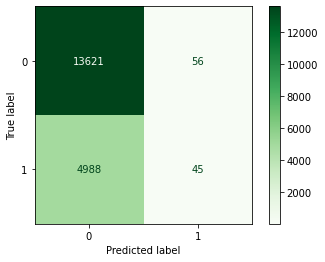

In [64]:
fig = plt.figure(figsize=(10, 10))
fig = plot_confusion_matrix(clf, X_train, y_train, cmap=plt.cm.Greens, values_format='')
plt.show()

# **¿Cómo afecta cada variable?**

In [65]:
model.intercept_

array([-1.10216113])

In [66]:
model.coef_

array([[-9.44136642e-03,  2.36546712e-01,  5.60152602e-02,
         1.35216332e-01,  1.10217954e+00, -1.50635437e-01,
         6.39581041e-01, -3.06649010e-01, -1.09388513e+00,
        -2.84483614e-01, -1.63384289e+00, -2.11709343e-02,
        -2.17620666e-01, -6.25244931e-02, -7.95446705e-02,
        -1.43663933e-01,  5.74552752e-01, -1.19829752e+00,
        -4.47489247e+01,  4.73880851e+01,  3.25493460e+01,
         1.00952662e+01, -1.75783477e+00,  1.40468035e+01,
         8.17249498e+00,  3.70730514e-01,  3.76554735e-03,
         7.74152281e-01, -4.12794963e-01,  5.73324541e-01,
         4.37396904e-01, -3.20151946e+00, -1.99224547e+02,
        -2.26485788e+00,  2.56271392e+01,  8.06710806e-01,
        -2.47788098e-01, -1.69830042e-01, -1.75100467e-01,
        -9.64131208e-01,  1.38982872e+00, -2.19663780e+02,
        -1.78977026e+02,  2.42907828e+01,  1.07321304e+01,
         0.00000000e+00]])

In [67]:
model.feature_names_in_

array(['L3_S29_F3315', 'L3_S29_F3318', 'L3_S29_F3321', 'L3_S29_F3324',
       'L3_S29_F3327', 'L3_S29_F3333', 'L3_S29_F3339', 'L3_S29_F3345',
       'L3_S29_F3351', 'L3_S29_F3354', 'L3_S29_F3357', 'L3_S29_F3360',
       'L3_S29_F3373', 'L3_S29_F3427', 'L3_S29_F3433', 'L3_S29_F3461',
       'L3_S29_F3464', 'L3_S29_F3473', 'L3_S29_F3482', 'L3_S29_F3485',
       'L3_S29_F3488', 'L3_S29_F3491', 'L3_S30_F3494', 'L3_S30_F3504',
       'L3_S30_F3509', 'L3_S30_F3514', 'L3_S30_F3519', 'L3_S30_F3524',
       'L3_S30_F3534', 'L3_S30_F3544', 'L3_S30_F3554', 'L3_S30_F3724',
       'L3_S30_F3729', 'L3_S30_F3734', 'L3_S30_F3739', 'L3_S30_F3744',
       'L3_S30_F3749', 'L3_S30_F3754', 'L3_S30_F3759', 'L3_S30_F3764',
       'L3_S30_F3829', 'L3_S37_F3944', 'L3_S37_F3946', 'L3_S37_F3948',
       'L3_S37_F3950', 'T_L3_S34_F3882'], dtype=object)

# **Posibilidades**


*   Agregar datos con variables categóricas:

  * Pro: Más datos importantes
  * Con: Complicaciones en la cantidad de datos

*   Imputación de datos:
  * Pro: Tener más datos al agregar algunos que habíamos descartado
  * Con: Podría no mejorar el modelo o presentar mas confusión en el dataset

